In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import ParameterGrid
import numpy as np

# Load and prepare the dataset
def load_and_prepare_data():
    train_data = pd.read_csv('train_data(new2).csv')
    val_data = pd.read_csv('val_data(new2).csv')
    test_data = pd.read_csv('test_data(new2).csv')

    train_data['Entry_Date'] = pd.to_datetime(train_data['Entry_Date'])
    val_data['Entry_Date'] = pd.to_datetime(val_data['Entry_Date'])
    test_data['Entry_Date'] = pd.to_datetime(test_data['Entry_Date'])

    train_data = train_data.sort_values(by='Entry_Date')
    val_data = val_data.sort_values(by='Entry_Date')
    test_data = test_data.sort_values(by='Entry_Date')

    return train_data, val_data, test_data

# Function for Walk-Forward Validation
def walk_forward_validation(train_data, features, target, n_splits=5):
    split_size = len(train_data) // (n_splits + 1)
    for i in range(n_splits):
        train_subset = train_data.iloc[:(i+1)*split_size]
        test_subset = train_data.iloc[(i+1)*split_size:(i+2)*split_size]
        
        X_train = train_subset[features]
        y_train = train_subset[target]
        X_test = test_subset[features]
        y_test = test_subset[target]
        
        yield X_train, y_train, X_test, y_test

# Train the model with walk-forward validation and evaluate on validation set
def train_with_walk_forward_validation(train_data, val_data, features, target, n_splits=5):
    param_grid = {
        'n_estimators': [20, 50],
        'max_depth': [10, 20],
        'min_samples_split': [50, 100],
        'min_samples_leaf': [10, 20],
    }

    best_score = 0
    best_params = None

    for params in ParameterGrid(param_grid):
        print(f"Training with parameters: {params}")
        total_roc_auc = 0
        
        for X_train, y_train, X_test, y_test in walk_forward_validation(train_data, features, target, n_splits):
            rf_clf = RandomForestClassifier(
                n_estimators=params['n_estimators'],
                max_depth=params['max_depth'],
                min_samples_split=params['min_samples_split'],
                min_samples_leaf=params['min_samples_leaf'],
                random_state=42
            )
            rf_clf.fit(X_train, y_train)

            calibrated_rf_clf = CalibratedClassifierCV(estimator=rf_clf, method='sigmoid')
            calibrated_rf_clf.fit(X_train, y_train)

            y_test_pred_proba = calibrated_rf_clf.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_test_pred_proba)
            total_roc_auc += roc_auc

        avg_roc_auc = total_roc_auc / n_splits
        print(f"Average ROC AUC: {avg_roc_auc}")
        
        if avg_roc_auc > best_score:
            best_score = avg_roc_auc
            best_params = params

    print(f"Best parameters from walk-forward validation: {best_params}")
    
    # Train final model on full training data with best parameters
    rf_clf = RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    )
    rf_clf.fit(train_data[features], train_data[target])
    
    calibrated_rf_clf = CalibratedClassifierCV(estimator=rf_clf, method='sigmoid')
    calibrated_rf_clf.fit(train_data[features], train_data[target])
    
    # Evaluate on validation set
    y_val_pred = calibrated_rf_clf.predict(val_data[features])
    y_val_pred_proba = calibrated_rf_clf.predict_proba(val_data[features])[:, 1]
    print("----- Validation Set Evaluation -----")
    print(classification_report(val_data[target], y_val_pred))
    roc_auc_val = roc_auc_score(val_data[target], y_val_pred_proba)
    print(f"Validation ROC AUC: {roc_auc_val}")

    return calibrated_rf_clf

# Final evaluation on the test set
def evaluate_on_test_set(model, test_data, features, target):
    y_test_pred = model.predict(test_data[features])
    y_test_pred_proba = model.predict_proba(test_data[features])[:, 1]
    print("----- Test Set Evaluation -----")
    print(classification_report(test_data[target], y_test_pred))
    roc_auc_test = roc_auc_score(test_data[target], y_test_pred_proba)
    print(f"Test ROC AUC: {roc_auc_test}")

    # Sort the test results by predicted probabilities
    test_results = pd.DataFrame({
        'Predicted_Probability': y_test_pred_proba,
        'Actual_Profit': test_data[target]
    })
    sorted_test_results = test_results.sort_values(by='Predicted_Probability', ascending=False)
    print("Sorted test results by predicted probabilities:")
    print(sorted_test_results)

    # Display top 10 predicted probabilities and actual profits
    top_n = 10
    top_n_results = sorted_test_results.head(top_n)
    print(f"Top {top_n} predicted probabilities and actual profits:")
    print(top_n_results)
    
    return sorted_test_results

train_data, val_data, test_data = load_and_prepare_data()

selected_features = [
    'SMA5_At_Entry', 'SMA10_At_Entry', 'EMA5_At_Entry', 'EMA15_At_Entry', 'RSI5_At_Entry', 'RSI10_At_Entry',
    'ATR5_At_Entry', 'ATR15_At_Entry', 'Stoch7_K_At_Entry', 'Stoch21_K_At_Entry',
    'BB10_High_At_Entry', 'BB10_Low_At_Entry', 'BB10_MAvg_At_Entry',
    'BB15_High_At_Entry', 'BB15_Low_At_Entry', 'BB15_MAvg_At_Entry',
    'High', 'Low', 'MACD_At_Entry', 'Day_Of_Week_At_Entry',
    'ROC14_At_Entry', 'ROC15_At_Entry'
]

target = 'Target'

# Train model with walk-forward validation and evaluate on validation set
calibrated_rf_clf = train_with_walk_forward_validation(train_data, val_data, selected_features, target, n_splits=5)

# Final evaluation on the test set
sorted_test_results = evaluate_on_test_set(calibrated_rf_clf, test_data, selected_features, target)

# Add predicted confidence to test_data for use in allocation methods
test_data['Predicted_Confidence'] = sorted_test_results['Predicted_Probability'].values


Training with parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 20}
Average ROC AUC: 0.5319936459483371
Training with parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 50}
Average ROC AUC: 0.5223355984840339
Training with parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 100, 'n_estimators': 20}
Average ROC AUC: 0.5350816843129792
Training with parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 100, 'n_estimators': 50}
Average ROC AUC: 0.5206235044984916
Training with parameters: {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 20}
Average ROC AUC: 0.5602709038375037
Training with parameters: {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 50}
Average ROC AUC: 0.5406825547073637
Training with parameters: {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 100, 'n_estimat

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score

# Load and prepare the dataset
def load_and_prepare_data():
    train_data = pd.read_csv('train_data(new2).csv')
    val_data = pd.read_csv('val_data(new2).csv')
    test_data = pd.read_csv('test_data(new2).csv')

    train_data['Entry_Date'] = pd.to_datetime(train_data['Entry_Date'])
    val_data['Entry_Date'] = pd.to_datetime(val_data['Entry_Date'])
    test_data['Entry_Date'] = pd.to_datetime(test_data['Entry_Date'])

    train_data = train_data.sort_values(by='Entry_Date')
    val_data = val_data.sort_values(by='Entry_Date')
    test_data = test_data.sort_values(by='Entry_Date')

    # train_data['Open_Last_Return'] = train_data['Open'] - train_data['Last'].shift(1)
    # val_data['Open_Last_Return'] = val_data['Open'] - val_data['Last'].shift(1)
    # test_data['Open_Last_Return'] = test_data['Open'] - test_data['Last'].shift(1)

    train_data.dropna(inplace=True)
    val_data.dropna(inplace=True)
    test_data.dropna(inplace=True)
    
    return train_data, val_data, test_data

# Train the model with provided parameters
def train_model(train_data, val_data, params, features, target):
    rf_clf = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=42
    )
    rf_clf.fit(train_data[features], train_data[target])
    
    # Apply Platt scaling
    calibrated_rf_clf = CalibratedClassifierCV(estimator=rf_clf, method='sigmoid')
    calibrated_rf_clf.fit(train_data[features], train_data[target])
    
    # Evaluate on validation set
    y_val_pred = calibrated_rf_clf.predict(val_data[features])
    y_val_pred_proba = calibrated_rf_clf.predict_proba(val_data[features])[:, 1]
    print("----- Validation Set Evaluation -----")
    print(classification_report(val_data[target], y_val_pred))
    roc_auc_val = roc_auc_score(val_data[target], y_val_pred_proba)
    print(f"Validation ROC AUC: {roc_auc_val}")
    
    return calibrated_rf_clf

# Final evaluation on the test set
def evaluate_on_test_set(model, test_data, features, target):
    y_test_pred = model.predict(test_data[features])
    y_test_pred_proba = model.predict_proba(test_data[features])[:, 1]
    print("----- Test Set Evaluation -----")
    print(classification_report(test_data[target], y_test_pred))
    roc_auc_test = roc_auc_score(test_data[target], y_test_pred_proba)
    print(f"Test ROC AUC: {roc_auc_test}")

    # Sort the test results by predicted probabilities
    test_results = pd.DataFrame({
        'Predicted_Probability': y_test_pred_proba,
        'Actual_Profit': test_data[target]
    })
    sorted_test_results = test_results.sort_values(by='Predicted_Probability', ascending=False)
    print("Sorted test results by predicted probabilities:")
    print(sorted_test_results)

    # Display top 10 predicted probabilities and actual profits
    top_n = 10
    top_n_results = sorted_test_results.head(top_n)
    print(f"Top {top_n} predicted probabilities and actual profits:")
    print(top_n_results)
    
    return sorted_test_results

train_data, val_data, test_data = load_and_prepare_data()

# Set the parameters for the model
params = {
    'n_estimators': 20,
    'max_depth': 20,
    'min_samples_split': 50,
    'min_samples_leaf': 20
}

# Define the features and target
selected_features = [
    'SMA5_At_Entry', 'SMA10_At_Entry', 'EMA5_At_Entry', 'EMA15_At_Entry', 'RSI5_At_Entry', 'RSI10_At_Entry',
    'ATR5_At_Entry', 'ATR15_At_Entry', 'Stoch7_K_At_Entry', 'Stoch21_K_At_Entry',
    'BB10_High_At_Entry', 'BB10_Low_At_Entry', 'BB10_MAvg_At_Entry',
    'BB15_High_At_Entry', 'BB15_Low_At_Entry', 'BB15_MAvg_At_Entry',
    'MACD_At_Entry', 'Day_Of_Week_At_Entry',
    'ROC14_At_Entry', 'ROC15_At_Entry', 'Open', 'Low', 'High', 'Last'
]

target = 'Target'

# Train the model with the specified parameters
calibrated_rf_clf = train_model(train_data, val_data, params, selected_features, target)

# Final evaluation on the test set
sorted_test_results = evaluate_on_test_set(calibrated_rf_clf, test_data, selected_features, target)

# Add predicted confidence to test_data for use in allocation methods
test_data['Predicted_Confidence'] = sorted_test_results['Predicted_Probability'].values


----- Validation Set Evaluation -----
              precision    recall  f1-score   support

         0.0       0.63      0.49      0.55       480
         1.0       0.55      0.69      0.61       442

    accuracy                           0.59       922
   macro avg       0.59      0.59      0.58       922
weighted avg       0.59      0.59      0.58       922

Validation ROC AUC: 0.6386783559577677
----- Test Set Evaluation -----
              precision    recall  f1-score   support

         0.0       0.62      0.49      0.55       475
         1.0       0.56      0.69      0.62       447

    accuracy                           0.59       922
   macro avg       0.59      0.59      0.58       922
weighted avg       0.59      0.59      0.58       922

Test ROC AUC: 0.6487012834098669
Sorted test results by predicted probabilities:
     Predicted_Probability  Actual_Profit
714               0.614259            1.0
713               0.614259            1.0
606               0.611248    

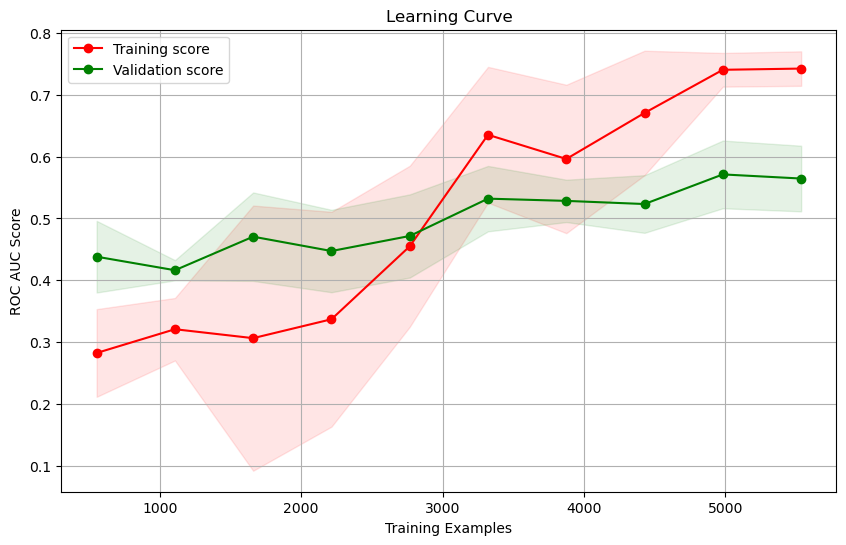

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# Function to plot the learning curve
def plot_learning_curve(model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure(figsize=(10, 6))
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation score")
    
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("ROC AUC Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Extracting the features and target for the training data
X_train = train_data[selected_features]
y_train = train_data[target]

# Plotting the learning curve for the calibrated model
plot_learning_curve(calibrated_rf_clf, X_train, y_train)


Equal allocation

/var/folders/zw/9vch0yrs50jfl_28l8p1__m80000gn/T/ipykernel_10797/3897819683.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, new_row], ignore_index=True)
/var/folders/zw/9vch0yrs50jfl_28l8p1__m80000gn/T/ipykernel_10797/3897819683.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, new_row], ignore_index=True)


Standard Approach Final Capital:
strategy_1: 30.90926014026028
strategy_2: -19.006850421209666
strategy_3: 63.61966430817517
strategy_4: 21.629632704555366
Standard Approach Total Profit/Loss: -2.8482932682188533

ML Approach Final Capital:
strategy_1: 55.31613388135173
strategy_2: 17.057537908839073
strategy_3: 49.673622860291346
strategy_4: 24.959029840493706
ML Approach Total Profit/Loss: 47.00632449097586


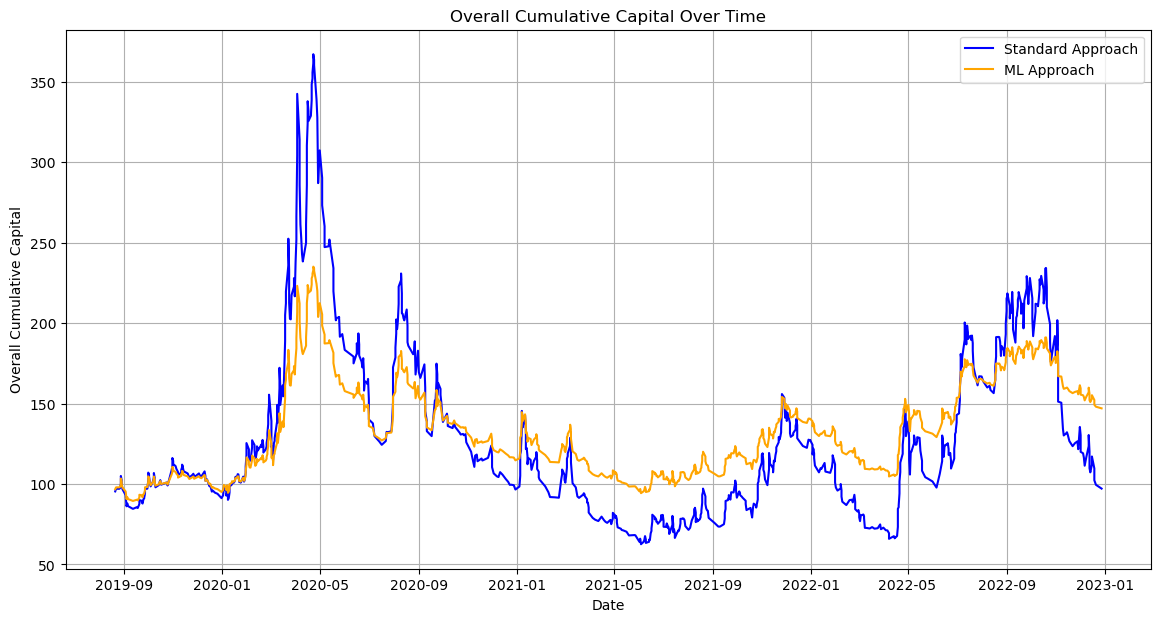

Standard Approach Metrics:
ROI: -0.03
Maximum Drawdown: -0.83
Sharpe Ratio: -0.23
Sortino Ratio: -0.37
Win Rate: 0.49

ML Approach Metrics:
ROI: 0.47
Maximum Drawdown: -0.60
Sharpe Ratio: -0.45
Sortino Ratio: -0.69
Win Rate: 0.49


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure Strategy_Code is correctly mapped to each Trade_ID
unique_strategies = test_data['Strategy'].unique()
strategy_mapping = {unique_strategies[i]: f'strategy_{i+1}' for i in range(len(unique_strategies))}
test_data['Strategy_Code'] = test_data['Strategy'].map(strategy_mapping)

# Verify that the mapping is correct
for strategy in unique_strategies:
    strategy_code = strategy_mapping[strategy]
    assert all(test_data[test_data['Strategy'] == strategy]['Strategy_Code'] == strategy_code), f"Mismatch in mapping for {strategy}"

# Initialize initial capital
initial_capital = 100  # Example initial capital

# Initialize dataframes to store capital allocation and cumulative capital for each approach
columns = ['Trade_ID', 'Strategy', 'Profit_Loss', 'Predicted_Confidence', 'Allocated_Capital', 'Strat_Cum', 'Total_Cum', 'Entry_Date']
standard_df = pd.DataFrame(columns=columns)
ml_df = pd.DataFrame(columns=columns)

# Initialize capital for standard and ML approaches
strategy_capital_standard = {strategy: initial_capital / len(unique_strategies) for strategy in strategy_mapping.values()}
strategy_capital_ml = {strategy: initial_capital / len(unique_strategies) for strategy in strategy_mapping.values()}

# Function to record a trade
def record_trade(df, trade_id, original_strategy, profit_loss, predicted_confidence, allocated_capital, cumulative_capital_strategy, cumulative_capital, entry_date):
    new_row = pd.DataFrame([{
        'Trade_ID': trade_id,
        'Strategy': original_strategy,  # Keep the original strategy label
        'Profit_Loss': profit_loss,
        'Predicted_Confidence': predicted_confidence,
        'Allocated_Capital': allocated_capital,
        'Strat_Cum': cumulative_capital_strategy,
        'Total_Cum': cumulative_capital,
        'Entry_Date': entry_date
    }])
    return pd.concat([df, new_row], ignore_index=True)

# Function to update and record trades for a given approach
def execute_trades(strategy_trades, strategy_capital, record_df, use_ml):
    cumulative_capital_strategy = {strategy: initial_capital / len(unique_strategies) for strategy in strategy_mapping.values()}
    cumulative_capital_overall = initial_capital
    
    for date, trades_on_date in test_data.groupby('Entry_Date'):
        total_capital = sum(strategy_capital.values())
        
        # Redistribute the total capital equally among all strategies
        allocated_capital = {s: total_capital / len(unique_strategies) for s in strategy_mapping.values()}
        
        for idx, trade in trades_on_date.iterrows():
            strategy = trade['Strategy_Code']
            original_strategy = trade['Strategy']  # Use the original strategy name
            trade_id = trade['Trade_ID']
            predicted_confidence = trade['Predicted_Confidence']
            profit_loss = trade['Profit_Loss']
            
            if use_ml:
                # Adjust allocation based on predicted confidence but not exceeding equal share
                adjusted_allocation = min(allocated_capital[strategy], allocated_capital[strategy] * predicted_confidence)
                
                # Update capital based on adjusted allocation and trade outcome
                strategy_capital[strategy] += adjusted_allocation * profit_loss
                cumulative_capital_strategy[strategy] += adjusted_allocation * profit_loss
                
                # Update overall cumulative capital
                cumulative_capital_overall += adjusted_allocation * profit_loss
                
                # Record the trade in the dataframe
                record_df = record_trade(
                    record_df, trade_id, original_strategy, profit_loss, predicted_confidence,
                    adjusted_allocation, cumulative_capital_strategy[strategy], cumulative_capital_overall, date
                )
            else:
                # Standard approach: equal allocation
                strategy_capital[strategy] += allocated_capital[strategy] * profit_loss
                cumulative_capital_strategy[strategy] += allocated_capital[strategy] * profit_loss
                
                # Update overall cumulative capital
                cumulative_capital_overall += allocated_capital[strategy] * profit_loss
                
                # Record the trade in the dataframe
                record_df = record_trade(
                    record_df, trade_id, original_strategy, profit_loss, predicted_confidence,
                    allocated_capital[strategy], cumulative_capital_strategy[strategy], cumulative_capital_overall, date
                )
    
    final_cumulative_capital = sum(strategy_capital.values())
    return record_df, final_cumulative_capital, cumulative_capital_strategy, cumulative_capital_overall

# Split the test data into the strategies based on the new mapping
strategy_trades = {strategy: test_data[test_data['Strategy_Code'] == strategy] for strategy in strategy_mapping.values()}

# Execute trades for the standard approach
standard_df, final_cumulative_capital_standard, final_cumulative_capital_strategy_standard, cumulative_capital_overall_standard = execute_trades(strategy_trades, strategy_capital_standard, standard_df, use_ml=False)

# Execute trades for the ML approach
ml_df, final_cumulative_capital_ml, final_cumulative_capital_strategy_ml, cumulative_capital_overall_ml = execute_trades(strategy_trades, strategy_capital_ml, ml_df, use_ml=True)

# Calculate total profit/loss
total_profit_loss_standard = final_cumulative_capital_standard - initial_capital
total_profit_loss_ml = final_cumulative_capital_ml - initial_capital

# Output the final capital for each strategy and total profit/loss
print("Standard Approach Final Capital:")
for strategy, capital in final_cumulative_capital_strategy_standard.items():
    print(f"{strategy}: {capital}")
print(f"Standard Approach Total Profit/Loss: {total_profit_loss_standard}")

print("\nML Approach Final Capital:")
for strategy, capital in final_cumulative_capital_strategy_ml.items():
    print(f"{strategy}: {capital}")
print(f"ML Approach Total Profit/Loss: {total_profit_loss_ml}")

# Save the dataframes to CSV files
standard_df.to_csv('standard_allocation(equalPLATT).csv', index=False)
ml_df.to_csv('ml_allocation(equalPLATT).csv', index=False)

# Plot overall cumulative capital over time for both methods on the same plot
plt.figure(figsize=(14, 7))

# Plot for the standard approach
plt.plot(standard_df['Entry_Date'], standard_df['Total_Cum'], label='Standard Approach', color='blue')

# Plot for the ML approach
plt.plot(ml_df['Entry_Date'], ml_df['Total_Cum'], label='ML Approach', color='orange')

plt.xlabel('Date')
plt.ylabel('Overall Cumulative Capital')
plt.title('Overall Cumulative Capital Over Time')
plt.legend()
plt.grid(True)
plt.savefig('overall_cumulative_capital_comparison.png')
plt.show()

# Function to calculate ROI
def calculate_roi(final_capital, initial_capital):
    return (final_capital - initial_capital) / initial_capital

# Function to calculate maximum drawdown
def calculate_max_drawdown(cumulative_returns):
    roll_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / roll_max - 1.0
    max_drawdown = drawdown.cummin().min()
    return max_drawdown

# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.01):
    excess_returns = returns - risk_free_rate
    return excess_returns.mean() / returns.std()

# Function to calculate Sortino ratio
def calculate_sortino_ratio(returns, risk_free_rate=0.01):
    downside_returns = returns[returns < risk_free_rate]
    expected_return = returns.mean() - risk_free_rate
    downside_deviation = downside_returns.std()
    return expected_return / downside_deviation

# Function to calculate win rate
def calculate_win_rate(profits):
    wins = (profits > 0).sum()
    total = len(profits)
    return wins / total

# Standard approach metrics
standard_roi = calculate_roi(final_cumulative_capital_standard, initial_capital)
standard_max_drawdown = calculate_max_drawdown(standard_df['Total_Cum'])
standard_returns = standard_df['Total_Cum'].pct_change().dropna()
standard_sharpe_ratio = calculate_sharpe_ratio(standard_returns)
standard_sortino_ratio = calculate_sortino_ratio(standard_returns)
standard_win_rate = calculate_win_rate(standard_df['Profit_Loss'])

# ML approach metrics
ml_roi = calculate_roi(final_cumulative_capital_ml, initial_capital)
ml_max_drawdown = calculate_max_drawdown(ml_df['Total_Cum'])
ml_returns = ml_df['Total_Cum'].pct_change().dropna()
ml_sharpe_ratio = calculate_sharpe_ratio(ml_returns)
ml_sortino_ratio = calculate_sortino_ratio(ml_returns)
ml_win_rate = calculate_win_rate(ml_df['Profit_Loss'])

# Print the metrics
print("Standard Approach Metrics:")
print(f"ROI: {standard_roi:.2f}")
print(f"Maximum Drawdown: {standard_max_drawdown:.2f}")
print(f"Sharpe Ratio: {standard_sharpe_ratio:.2f}")
print(f"Sortino Ratio: {standard_sortino_ratio:.2f}")
print(f"Win Rate: {standard_win_rate:.2f}")

print("\nML Approach Metrics:")
print(f"ROI: {ml_roi:.2f}")
print(f"Maximum Drawdown: {ml_max_drawdown:.2f}")
print(f"Sharpe Ratio: {ml_sharpe_ratio:.2f}")
print(f"Sortino Ratio: {ml_sortino_ratio:.2f}")
print(f"Win Rate: {ml_win_rate:.2f}")


All-in

/var/folders/zw/9vch0yrs50jfl_28l8p1__m80000gn/T/ipykernel_10797/2621305836.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, new_row], ignore_index=True)
/var/folders/zw/9vch0yrs50jfl_28l8p1__m80000gn/T/ipykernel_10797/2621305836.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, new_row], ignore_index=True)


Naive 'All-in' Approach Final Capital:
strategy_1: -120.81523680582629
strategy_2: 253.08464682813124
strategy_3: 110.14102461790958
strategy_4: 57.778874400941504
Naive 'All-in' Approach Total Profit/Loss: -99.81069095884388

ML 'All-in' Approach Final Capital:
strategy_1: 35.04552810031242
strategy_2: 109.38919933514403
strategy_3: 120.8160864202227
strategy_4: 69.13007960833271
ML 'All-in' Approach Total Profit/Loss: -65.61910653598825


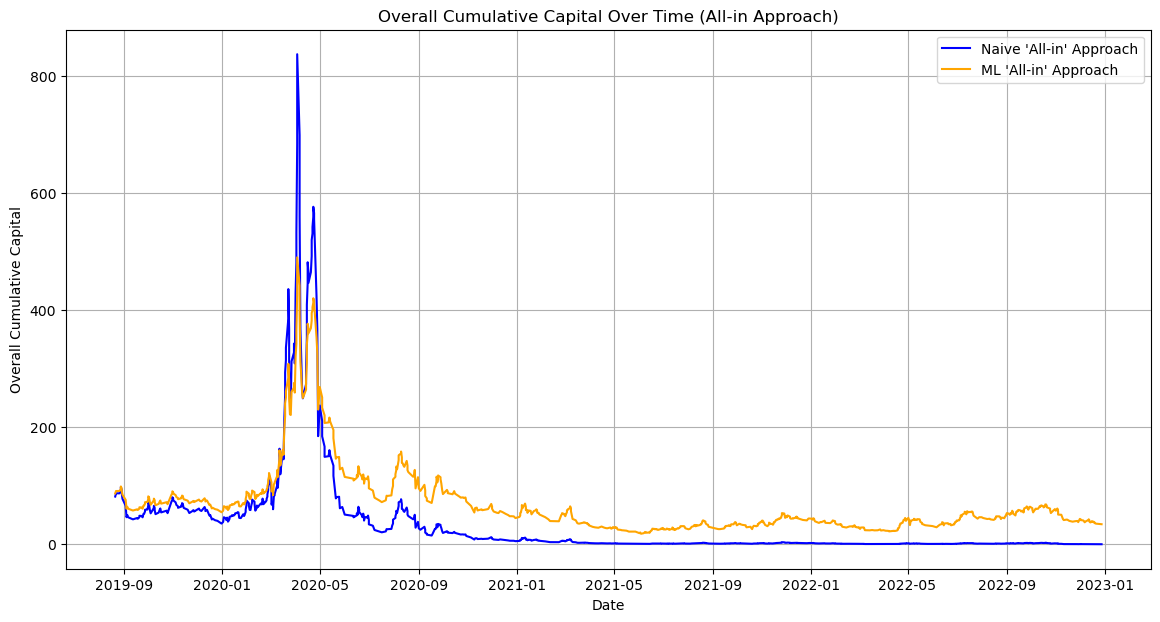

Standard Approach Metrics:
ROI: -1.00
Maximum Drawdown: -1.00
Sharpe Ratio: -0.09
Sortino Ratio: -0.13
Win Rate: 0.49

ML Approach Metrics:
ROI: -0.66
Maximum Drawdown: -0.96
Sharpe Ratio: -0.15
Sortino Ratio: -0.24
Win Rate: 0.49


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure Strategy_Code is correctly mapped to each Trade_ID
unique_strategies = test_data['Strategy'].unique()
strategy_mapping = {unique_strategies[i]: f'strategy_{i+1}' for i in range(len(unique_strategies))}
test_data['Strategy_Code'] = test_data['Strategy'].map(strategy_mapping)

# Verify that the mapping is correct
for strategy in unique_strategies:
    strategy_code = strategy_mapping[strategy]
    assert all(test_data[test_data['Strategy'] == strategy]['Strategy_Code'] == strategy_code), f"Mismatch in mapping for {strategy}"

# Initialize initial capital
initial_capital = 100  # Example initial capital

# Initialize dataframes to store capital allocation and cumulative capital for each approach
columns = ['Trade_ID', 'Strategy', 'Profit_Loss', 'Predicted_Confidence', 'Allocated_Capital', 'Strat_Cum', 'Total_Cum', 'Entry_Date']
standard_df = pd.DataFrame(columns=columns)
ml_df = pd.DataFrame(columns=columns)

# Function to record a trade
def record_trade(df, trade_id, original_strategy, profit_loss, predicted_confidence, allocated_capital, cumulative_capital_strategy, cumulative_capital, entry_date):
    new_row = pd.DataFrame([{
        'Trade_ID': trade_id,
        'Strategy': original_strategy,  # Keep the original strategy label
        'Profit_Loss': profit_loss,
        'Predicted_Confidence': predicted_confidence,
        'Allocated_Capital': allocated_capital,
        'Strat_Cum': cumulative_capital_strategy,
        'Total_Cum': cumulative_capital,
        'Entry_Date': entry_date
    }])
    return pd.concat([df, new_row], ignore_index=True)

# Function to update and record trades for both approaches
def execute_trades(strategy_trades, record_df, use_ml):
    cumulative_capital_strategy = {strategy: initial_capital for strategy in strategy_mapping.values()}
    cumulative_capital_overall = initial_capital
    
    for date, trades_on_date in test_data.groupby('Entry_Date'):
        active_trades = trades_on_date.shape[0]
        total_capital = cumulative_capital_overall
        
        if active_trades > 0:
            if use_ml:
                # ML approach: Start with equal allocation and then scale by predicted confidence
                trades_on_date['Base_Allocation'] = total_capital / active_trades
                trades_on_date['Allocated_Capital'] = trades_on_date['Base_Allocation'] * trades_on_date['Predicted_Confidence']
            else:
                # Standard naive approach: Allocate capital equally among active trades
                trades_on_date['Allocated_Capital'] = total_capital / active_trades
            
            for idx, trade in trades_on_date.iterrows():
                strategy = trade['Strategy_Code']
                original_strategy = trade['Strategy']
                trade_id = trade['Trade_ID']
                predicted_confidence = trade['Predicted_Confidence']
                profit_loss = trade['Profit_Loss']
                allocated_capital = trade['Allocated_Capital']
                
                # Update capital based on allocated capital and trade outcome
                cumulative_capital_strategy[strategy] += allocated_capital * profit_loss
                cumulative_capital_overall += allocated_capital * profit_loss
                
                # Record the trade in the dataframe
                record_df = record_trade(
                    record_df, trade_id, original_strategy, profit_loss, predicted_confidence,
                    allocated_capital, cumulative_capital_strategy[strategy], cumulative_capital_overall, date
                )
    
    final_cumulative_capital = cumulative_capital_overall
    return record_df, final_cumulative_capital, cumulative_capital_strategy

# Split the test data into the strategies based on the new mapping
strategy_trades = {strategy: test_data[test_data['Strategy_Code'] == strategy] for strategy in strategy_mapping.values()}

# Execute trades for the standard approach using the all-in method
standard_df, final_cumulative_capital_standard, final_cumulative_capital_strategy_standard = execute_trades(strategy_trades, standard_df, use_ml=False)

# Execute trades for the ML approach using the all-in method with scaled confidence
ml_df, final_cumulative_capital_ml, final_cumulative_capital_strategy_ml = execute_trades(strategy_trades, ml_df, use_ml=True)

# Calculate total profit/loss
total_profit_loss_standard = final_cumulative_capital_standard - initial_capital
total_profit_loss_ml = final_cumulative_capital_ml - initial_capital

# Output the final capital for each strategy and total profit/loss
print("Naive 'All-in' Approach Final Capital:")
for strategy, capital in final_cumulative_capital_strategy_standard.items():
    print(f"{strategy}: {capital}")
print(f"Naive 'All-in' Approach Total Profit/Loss: {total_profit_loss_standard}")

print("\nML 'All-in' Approach Final Capital:")
for strategy, capital in final_cumulative_capital_strategy_ml.items():
    print(f"{strategy}: {capital}")
print(f"ML 'All-in' Approach Total Profit/Loss: {total_profit_loss_ml}")

# Save the dataframes to CSV files
standard_df.to_csv('standard_all_in_allocation.csv', index=False)
ml_df.to_csv('ml_all_in_allocation.csv', index=False)

# Plot overall cumulative capital over time for both methods on the same plot
plt.figure(figsize=(14, 7))

# Plot for the standard approach
plt.plot(standard_df['Entry_Date'], standard_df['Total_Cum'], label="Naive 'All-in' Approach", color='blue')

# Plot for the ML approach
plt.plot(ml_df['Entry_Date'], ml_df['Total_Cum'], label="ML 'All-in' Approach", color='orange')

plt.xlabel('Date')
plt.ylabel('Overall Cumulative Capital')
plt.title('Overall Cumulative Capital Over Time (All-in Approach)')
plt.legend()
plt.grid(True)
plt.savefig('all_in_cumulative_capital_comparison.png')
plt.show()

# The performance metrics calculations can remain the same as in your equal approach.

# Function to calculate ROI
def calculate_roi(final_capital, initial_capital):
    return (final_capital - initial_capital) / initial_capital

# Function to calculate maximum drawdown
def calculate_max_drawdown(cumulative_returns):
    roll_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / roll_max - 1.0
    max_drawdown = drawdown.cummin().min()
    return max_drawdown

# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.01):
    excess_returns = returns - risk_free_rate
    return excess_returns.mean() / returns.std()

# Function to calculate Sortino ratio
def calculate_sortino_ratio(returns, risk_free_rate=0.01):
    downside_returns = returns[returns < risk_free_rate]
    expected_return = returns.mean() - risk_free_rate
    downside_deviation = downside_returns.std()
    return expected_return / downside_deviation

# Function to calculate win rate
def calculate_win_rate(profits):
    wins = (profits > 0).sum()
    total = len(profits)
    return wins / total

# Standard approach metrics
standard_roi = calculate_roi(final_cumulative_capital_standard, initial_capital)
standard_max_drawdown = calculate_max_drawdown(standard_df['Total_Cum'])
standard_returns = standard_df['Total_Cum'].pct_change().dropna()
standard_sharpe_ratio = calculate_sharpe_ratio(standard_returns)
standard_sortino_ratio = calculate_sortino_ratio(standard_returns)
standard_win_rate = calculate_win_rate(standard_df['Profit_Loss'])

# ML approach metrics
ml_roi = calculate_roi(final_cumulative_capital_ml, initial_capital)
ml_max_drawdown = calculate_max_drawdown(ml_df['Total_Cum'])
ml_returns = ml_df['Total_Cum'].pct_change().dropna()
ml_sharpe_ratio = calculate_sharpe_ratio(ml_returns)
ml_sortino_ratio = calculate_sortino_ratio(ml_returns)
ml_win_rate = calculate_win_rate(ml_df['Profit_Loss'])

# Print the metrics
print("Standard Approach Metrics:")
print(f"ROI: {standard_roi:.2f}")
print(f"Maximum Drawdown: {standard_max_drawdown:.2f}")
print(f"Sharpe Ratio: {standard_sharpe_ratio:.2f}")
print(f"Sortino Ratio: {standard_sortino_ratio:.2f}")
print(f"Win Rate: {standard_win_rate:.2f}")

print("\nML Approach Metrics:")
print(f"ROI: {ml_roi:.2f}")
print(f"Maximum Drawdown: {ml_max_drawdown:.2f}")
print(f"Sharpe Ratio: {ml_sharpe_ratio:.2f}")
print(f"Sortino Ratio: {ml_sortino_ratio:.2f}")
print(f"Win Rate: {ml_win_rate:.2f}")